<a href="https://colab.research.google.com/github/RozitaAbdoli/credit_default_mining/blob/main/Model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Comparing the performance of multiple ML algorithms
In this notebook, the performance of several ML algorithms will be evaluated based on their effectiveness, efficiency, and stability.

The ML models include:    
1. Individual classification techniques:    
"Logistic Regression", "KNN", "Naive Bayes", "SVM_RBF", and "Decision Tree"
2. Homogeneous ensemble learners:    
 "Random Forest", "AdaBoost", "GradientBoost", "XGBoost"

 They use Decision Trees as weak learners and:  

* Are non-parametric and don't require data to be normally distributed.
* Can handle both numeric and categorical data types, and categorical predictors don't have to be one-hot encoded.
* The correlation between predictors does not affect the performance of the model.

3. A heterogeneous ensemble learner:  

  Since the performance of RF, GradientBoost, and XGBoost are close, can develop a heterogenous ensemble learner that sums the probabilities for each class from these 3 models, and predicts the class with the higher overall probability to test whether this improves overall performance.



In [35]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
# from sklearn.neural_network import MLPClassifier
from sklearn import svm
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score, brier_score_loss

import time

from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
# from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [36]:
#Change the global figure parameters using pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 22,
         'axes.titlesize':18,
         'xtick.labelsize':18,
         'ytick.labelsize':18}
pylab.rcParams.update(params)

In [37]:
# #Import Drive API and authenticate
# from google.colab import drive
# #Mount Drive to the Colab VM
# drive.mount('/content/drive')

In [38]:
#Load the dataset into pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Capstone_project/v2_credit_default.csv")

In [39]:
# #  Selected features Based on Pearson and Spearman's rank correlations with the dependent variable, and XGBoost feature importance rankings:
# df = df[['AGE', 'LIMIT_BAL', 'Pay_Apr', 'Repay_Sept', 'Pay_Sept','Default' ]]
# df = df[['Repay_sept', 'Repay_Aug', 'Repay_July', 'SEX', 'MARRIAGE','Default' ]]

In [40]:
df.shape

(29965, 24)

In [41]:
#Seperate the independent and dependent variables.
X = df.drop(['Default'], axis=1)
y = df['Default']

## 1. Cross-validation step:    

In [42]:
#List the classifiers to be compared
names = ["Logistic Regression","KNN", "Naive Bayes","SVM_RBF", "Decision Tree", "Random Forest", "AdaBoost", "GradientBoost", "XGBoost", "Heterogeneous_ensemble"] 
# define the base models for the heterogenous ensemble
base_models = list()
base_models.append(('RF', RandomForestClassifier()))
# base_models.append(('AB', AdaBoostClassifier()))
base_models.append(('GB', GradientBoostingClassifier()))
base_models.append(('XGB', xgb.XGBClassifier()))
# Now define the models including changing any of the default hyperparameters
clfs = [
    LogisticRegression(random_state=1, C= 50, penalty= 'l1', solver= 'liblinear'),
    KNeighborsClassifier(),                           #n_neighbors=5 
    GaussianNB(),
    svm.SVC(kernel ='rbf'),               #SVM model does not have the best performance, but takes a long time, therefore omitted here.
    DecisionTreeClassifier(),              #set max_depth 
    RandomForestClassifier(),        #bootstrap aggregation or bagging
    AdaBoostClassifier(), 
    GradientBoostingClassifier(),    #also tried GridSearchCV result {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 200}
    XGBClassifier(), 
    VotingClassifier(estimators=base_models, voting='soft')     #soft voting sums the probabilities for each class from each model
] 

In [43]:
# record the perfromance metrics and SD between runs
accuracies = []
accuracy_stds = []
precisions = []
precision_stds = []
recalls = []
recall_stds = []
f1_scores = []
f1_stds = []
roc_aucs = []
auc_stds = []
# neg_brier_scores = []

elapsed_time = []

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)     #3 repeats of k=10-fold  
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc' }

for name, clf in zip(names, clfs):
# define a pipeline so the scaling is only applied to the training data for each repetition of k-fold
  steps = list()
  steps.append(('scaler', preprocessing.MinMaxScaler()))
  steps.append(('model', clf))
  pipeline = Pipeline(steps=steps)

  start = time.time()

  scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)

  end = time.time()
  elapsed = end - start
  elapsed_time.append(elapsed)

  accuracies.append(mean(scores['test_accuracy']))
  accuracy_stds.append(std(scores['test_accuracy']))

  precisions.append(mean(scores['test_precision']))
  precision_stds.append(std(scores['test_precision']))

  recalls.append(mean(scores['test_recall']))
  recall_stds.append(std(scores['test_recall']))

  f1_scores.append(mean(scores['test_f1']))
  f1_stds.append(std(scores['test_f1']))

  roc_aucs.append(mean(scores['test_roc_auc']))
  auc_stds.append(std(scores['test_roc_auc']))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [44]:
# Performance metrics dataframe with cross validation
CV_scores_df = pd.DataFrame()
CV_scores_df['Algorithm'] = names

CV_scores_df['Accuracy'] = accuracies
CV_scores_df['Accuracy_SD'] = accuracy_stds

CV_scores_df['Precision'] = precisions
CV_scores_df['Precision_SD'] = precision_stds

CV_scores_df['Recall'] = recalls
CV_scores_df['Recall_SD'] = recall_stds

CV_scores_df['F1_score'] = f1_scores 
CV_scores_df['F1_SD'] = f1_stds 

CV_scores_df['ROC_AUC'] = roc_aucs  
CV_scores_df['AUC_SD'] = auc_stds 

CV_scores_df['Elapsed_time'] = elapsed_time

CV_scores_df

,Algorithm,Accuracy,Accuracy_SD,Precision,Precision_SD,Recall,Recall_SD,F1_score,F1_SD,ROC_AUC,AUC_SD,Elapsed_time
0,Logistic Regression,0.810868,0.004387,0.716905,0.028847,0.240171,0.014797,0.359605,0.018812,0.722915,0.009587,134.726761
1,KNN,0.793592,0.005602,0.554596,0.021272,0.342584,0.017841,0.423304,0.017477,0.703251,0.009071,67.507574
2,Naive Bayes,0.712775,0.025635,0.408887,0.028461,0.648316,0.023470,0.500537,0.019842,0.736603,0.011954,1.241704
3,SVM_RBF,0.818199,0.003977,0.693433,0.022119,0.320211,0.013977,0.437897,0.014696,0.714953,0.010180,975.213097
4,Decision Tree,0.726125,0.008444,0.389614,0.015227,0.418150,0.015779,0.403226,0.013340,0.616284,0.009182,16.349869
5,Random Forest,0.815529,0.004895,0.645555,0.020138,0.369130,0.016668,0.469499,0.016621,0.762564,0.009898,186.043674
6,AdaBoost,0.816809,0.005580,0.682454,0.025949,0.321820,0.018264,0.437202,0.020713,0.774589,0.010290,56.687293
7,GradientBoost,0.821080,0.005344,0.677573,0.022572,0.365259,0.016868,0.474497,0.018145,0.782471,0.009023,246.017208
8,XGBoost,0.821492,0.005388,0.681045,0.022597,0.363499,0.017127,0.473862,0.018555,0.782632,0.009191,69.937810
9,Heterogeneous_ensemble,0.821180,0.005154,0.676823,0.022522,0.367371,0.015784,0.476098,0.017004,0.783069,0.008904,500.614467


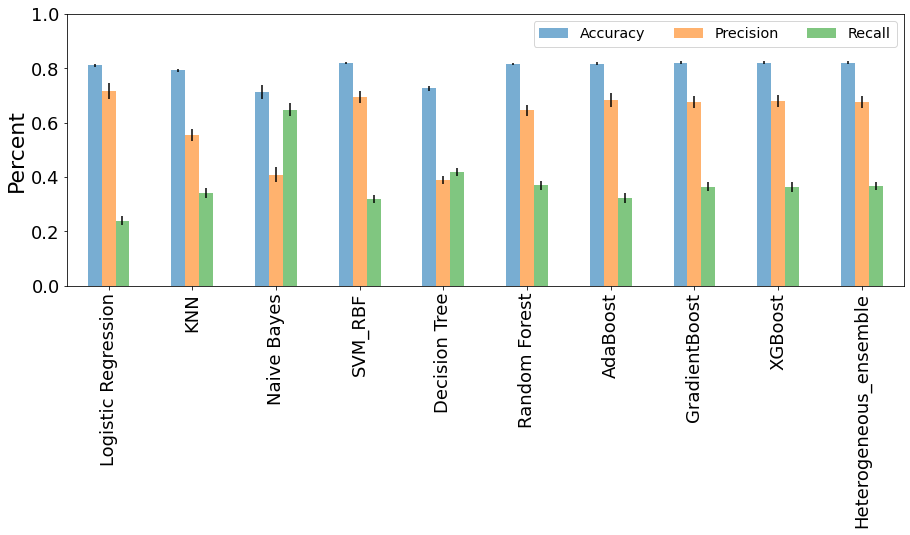

In [45]:
# visual representation of the performance metrics above
yerr = CV_scores_df[['Accuracy_SD', 'Precision_SD', 'Recall_SD']].to_numpy().T
CV_scores_df[['Accuracy', 'Precision','Recall']].plot(kind='bar', yerr=yerr, alpha=0.6)
plt.xticks(CV_scores_df.index, CV_scores_df["Algorithm"].values)
plt.ylim([0, 1])
plt.ylabel("Percent")
plt.legend(loc="upper right", ncol=len(df.columns))
plt.show()

## 2. (optional) Classic train-test step on the best performing model:    

In [46]:
# # Now the classic train-test split, but iterated 50 times. This will be slower than CV, and therefore is only done for the best-performing model.
# # The test set is unseen by the model, and therefore there is no chance of knowledge leaking.
# # If everything has gone right, this model should perform the same with train-test split here as it did with cross-validation above.
# accuracies = []
# precisions = []
# recalls = []
# f1s = []
# aucs = []

# for i in range(50):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#     best_model = XGBClassifier() 

#     # fit the scaler to the training data, and apply the same scaling to the test data
#     scale= preprocessing.MinMaxScaler()
#     X_train = scale.fit_transform(X_train)
#     X_test = scale.transform(X_test)

#     #balance training data using SMOTETomek
#     smt = SMOTETomek(random_state=42)
#     X_train, y_train = smt.fit_resample(X_train, y_train)

#     best_model.fit(X_train, y_train)
#     y_pred = best_model.predict(X_test)

#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     y_pred_proba = best_model.predict_proba(X_test)[::, 1]
#     auc = roc_auc_score(y_test, y_pred_proba)
#     accuracies.append(accuracy)
#     precisions.append(precision)
#     recalls.append(recall)
#     f1s.append(f1)
#     aucs.append(auc)

# print(mean(accuracies),
#       mean(precisions),
#       mean(recalls),
#       mean(f1s),
#       mean(aucs)
#       )
# # Results of CV:                   0.821080	0.677572	0.365259	0.474495	0.782465
# # Results of train-test (50 runs): 0.803212  0.561965  0.492941  0.525044  0.768300
# # Note: can see a slightly higher recall and f1-score. This can be the result of balancing with SMOTE-Tomek

______________________________


## 3. (optional) Train-test step with every model:    
* Can calculate model efficiency (time it takes to train the model)
* Can see if there are models, other than the top-performing model above, that might benefit from data engineering (balancing, normalizing) and would be woth exploring further.

In [47]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)   #random_state=1

In [48]:
# fit the scaler to the training data, and apply the same scaling to the test data
scale= preprocessing.MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [49]:
#Balance training data using SMOTETomek
smt = SMOTETomek(random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train) 

In [50]:
#An alternative, less robust but faster option is to have training on the training set, and testing on the test set (no validation set).
# This will only give us 1 number for each performance metric.
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []
# neg_brier_scores = []

elapsed_time = []

for name, clf in zip(names, clfs):
    start = time.time()

    clf.fit(X_train, y_train.values.ravel())

    end = time.time()
    elapsed = end - start
    elapsed_time.append(elapsed)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    precision = precision_score(y_test, y_pred)
    precisions.append(precision)

    recall = recall_score(y_test, y_pred)
    recalls.append(recall)

    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)


In [51]:
#Precision= TP/(TP+FP), Recall= TP/(TP+FN)
scores_df = pd.DataFrame()
scores_df['Algorithm'] = names
scores_df['Accuracy'] = accuracies
scores_df['Precision'] = precisions
scores_df['Recall'] = recalls
scores_df['F1_score'] = f1_scores
scores_df['Elapsed-time(s)'] = elapsed_time 
scores_df

,Algorithm,Accuracy,Precision,Recall,F1_score,Elapsed-time(s)
0,Logistic Regression,0.677308,0.364966,0.649821,0.467413,7.793242
1,KNN,0.675417,0.355616,0.602859,0.447348,0.003971
2,Naive Bayes,0.402336,0.252465,0.888719,0.393224,0.031143
3,SVM_RBF,0.777753,0.491436,0.571210,0.528329,60.152708
4,Decision Tree,0.709010,0.366626,0.460949,0.408412,0.798301
5,Random Forest,0.798331,0.543042,0.470138,0.503967,9.899311
6,AdaBoost,0.771635,0.478905,0.544666,0.509673,3.802294
7,GradientBoost,0.806007,0.564103,0.482899,0.520352,16.873327
8,XGBoost,0.806340,0.565114,0.482899,0.520782,3.632739
9,Heterogeneous_ensemble,0.807119,0.567004,0.485962,0.523364,30.579514


Some notes:

* Scaling inputs between 0 and 1 did not affect the performance of the models much.
* Can see the trade-off between precision and recall in this algorithms: when precision is higher recall suffers, and vice versa.

In [52]:
#Change the global figure parameters for the plot below
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (25, 5),
         'axes.labelsize': 22,
         'axes.titlesize':22,
         'xtick.labelsize':18,
         'ytick.labelsize':18}
pylab.rcParams.update(params)

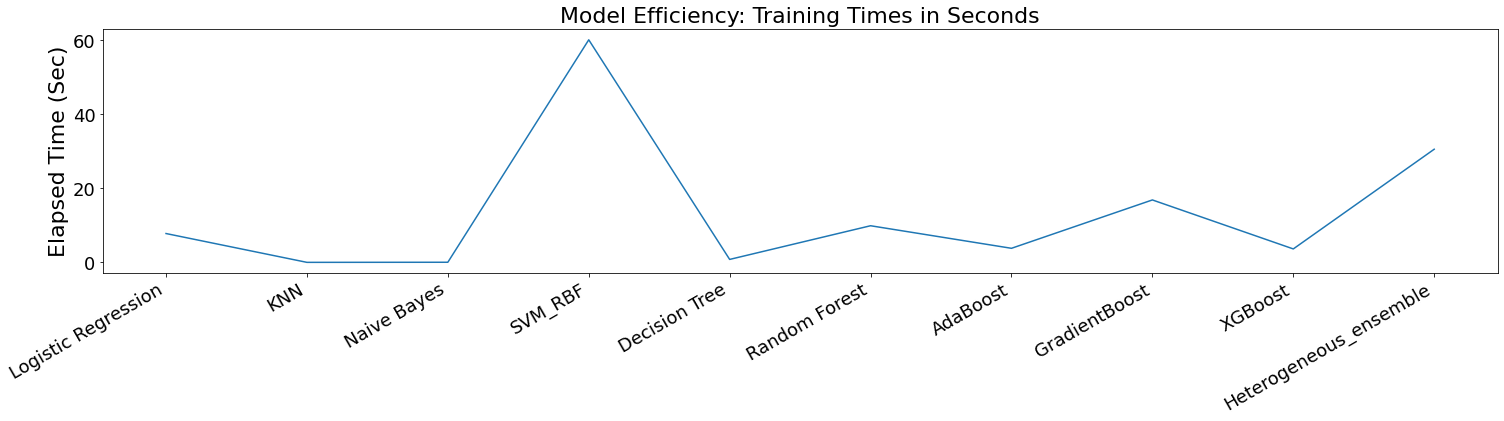

In [53]:
# Plotting the time it took each model to train
scores_df.plot(x="Algorithm", y=["Elapsed-time(s)"], subplots=True, legend=None)
plt.xticks(range(0,len(scores_df.Algorithm)), scores_df.Algorithm)
plt.xlabel(xlabel=None)
plt.ylabel('Elapsed Time (Sec)')
plt.title('Model Efficiency: Training Times in Seconds')
plt.show()

In [54]:
# CPU information
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [55]:
# RAM
!free -h --si | awk  '/Mem:/{print $2}'

13G


In [56]:
#Change the global figure parameters for the plot below
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (25, 10),
         'axes.labelsize': 22,
         'axes.titlesize':22,
         'xtick.labelsize':18,
         'ytick.labelsize':18}
pylab.rcParams.update(params)

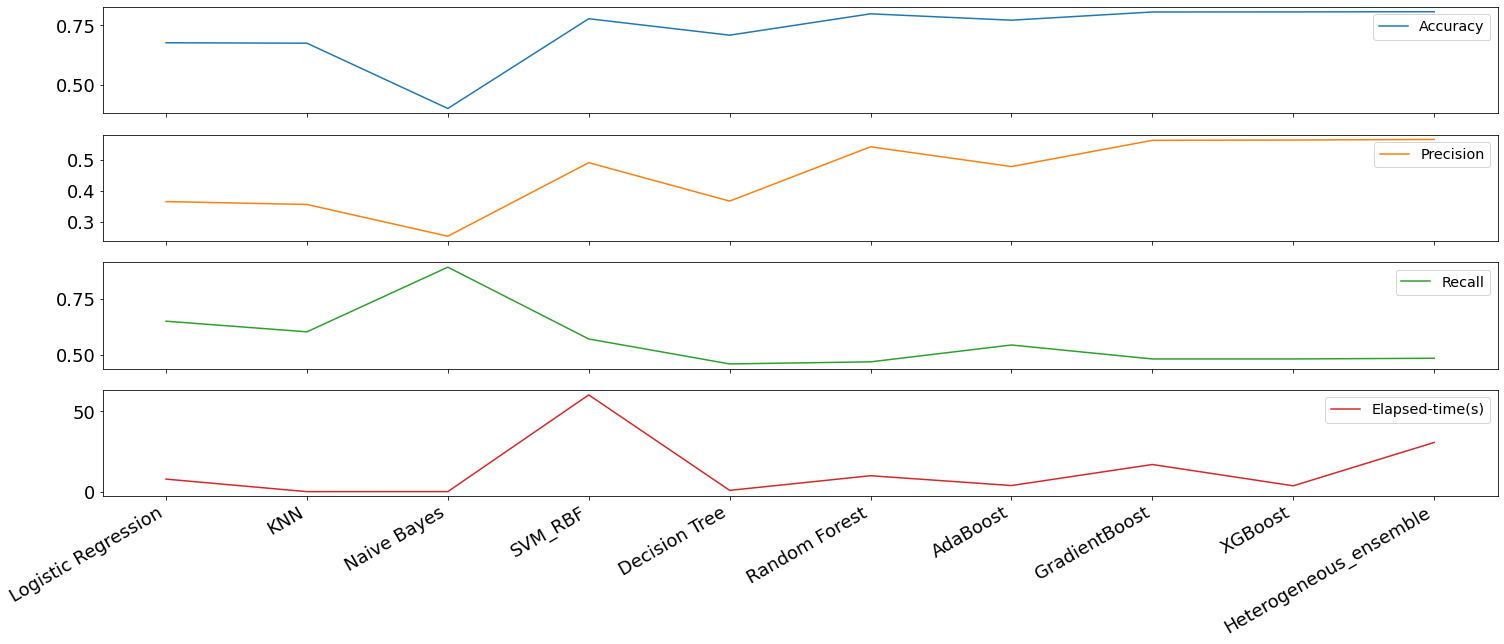

In [57]:
## Plot all attribues as subplots
scores_df.plot(x="Algorithm", y=["Accuracy", "Precision", "Recall", "Elapsed-time(s)"], subplots=True)
plt.xticks(range(0,len(scores_df.Algorithm)), scores_df.Algorithm)
plt.xlabel(None)
plt.show()

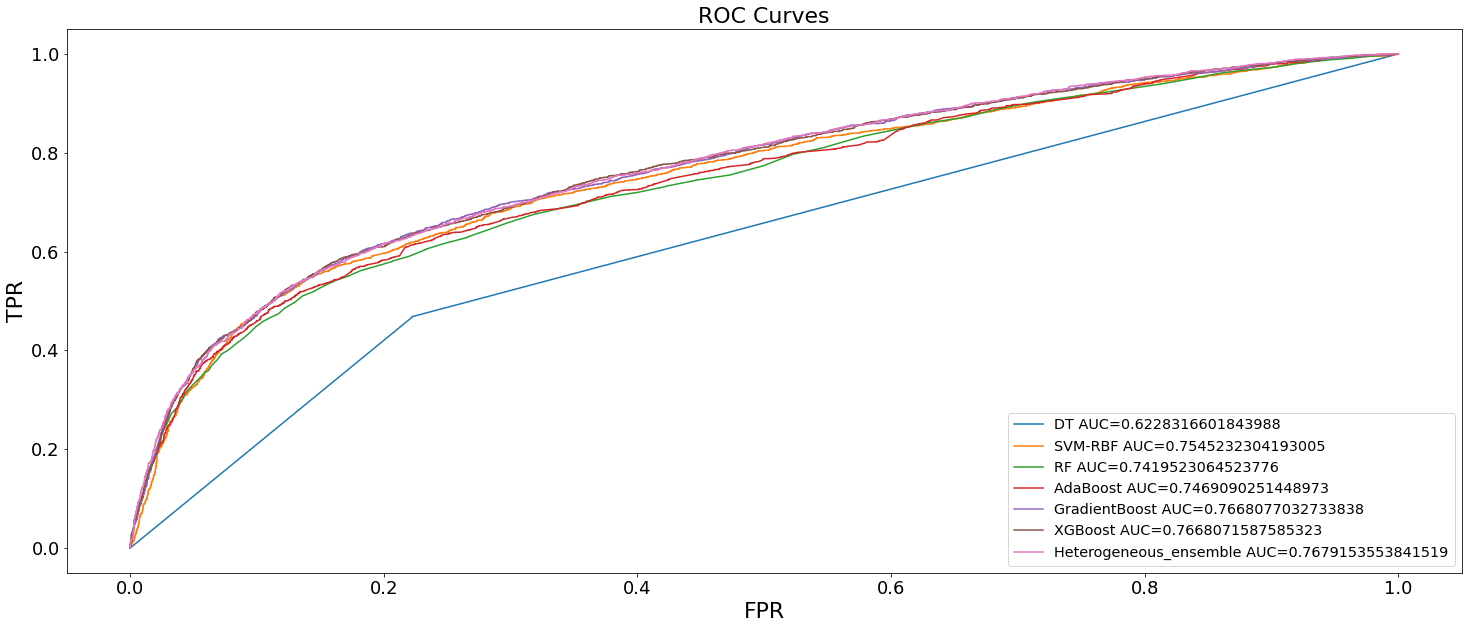

In [58]:
# The ROC curves and the ROC AUC
# TPR = True Positive Rate = True Positives / (True Positives + False Negatives)
# FPR = False Positive Rate = 1 - Specificity = False Positives / (False Positives + True Negatives)
# The value of AUC ranges from 0.5 (poor discriminative capability or random guess) to 1 (perfect discriminative capability).

dtc = DecisionTreeClassifier()              #set max_depth 
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
y_pred_proba = dtc.predict_proba(X_test)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="DT AUC="+str(auc))

SVM_RBF = svm.SVC(kernel ='rbf', probability=True)              
SVM_RBF.fit(X_train, y_train)
y_pred = SVM_RBF.predict(X_test)
y_pred_proba = SVM_RBF.predict_proba(X_test)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="SVM-RBF AUC="+str(auc))

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_pred_proba = rfc.predict_proba(X_test)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="RF AUC="+str(auc))

abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
y_pred = abc.predict(X_test)
y_pred_proba = abc.predict_proba(X_test)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="AdaBoost AUC="+str(auc))

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
y_pred_proba = gbc.predict_proba(X_test)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="GradientBoost AUC="+str(auc))

xgbc = XGBClassifier() 
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
y_pred_proba = xgbc.predict_proba(X_test)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="XGBoost AUC="+str(auc))

heterogenous_ensemble = VotingClassifier(estimators=base_models, voting='soft')
heterogenous_ensemble.fit(X_train, y_train)
y_pred = heterogenous_ensemble.predict(X_test)
y_pred_proba = heterogenous_ensemble.predict_proba(X_test)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="Heterogeneous_ensemble AUC="+str(auc))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend(loc=4) 
plt.show()

## 4. Comparing feature importances

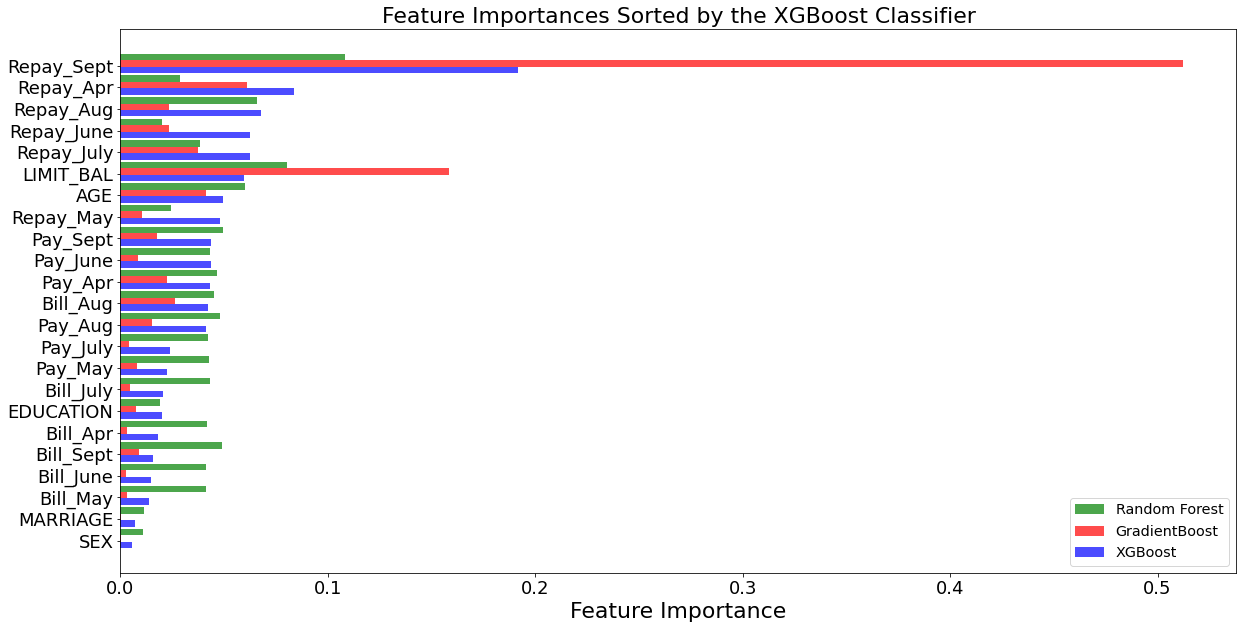

In [59]:
#plot feature importances for the top 3 models
# Sort by the important features of RF since RF is more robust to varying hyperparameters than the boosting algorithms.
feature_importance=pd.DataFrame({
    'rfc':rfc.feature_importances_,
    'gbc':gbc.feature_importances_,
    'xgbc':xgbc.feature_importances_
},
index=df.drop(columns=['Default']).columns)

feature_importance.sort_values(by='xgbc',ascending=True,inplace=True)

index = np.arange(len(feature_importance))
fig, ax = plt.subplots(figsize=(20,10))

rfc_feature=ax.barh(index+0.9,feature_importance['rfc'],0.3,color='green',label='Random Forest', alpha=0.7)
gbc_feature=ax.barh(index+0.6,feature_importance['gbc'],0.3,color='red',label='GradientBoost', alpha=0.7)
xgbc_feature=ax.barh(index+0.3,feature_importance['xgbc'],0.3,color='blue',label='XGBoost', alpha=0.7)

ax.set(yticks=index+0.5,yticklabels=feature_importance.index)

plt.title("Feature Importances Sorted by the XGBoost Classifier")
plt.xlabel('Feature Importance')
plt.legend(loc=4)
plt.show()
#Top 3:Repay_Sept, LIMIT_BAL, AGE